In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime
import unicodedata
from pylab import rcParams
import os

In [2]:
rcParams['figure.figsize'] = 16,10
rcParams['font.size'] = 20

In [3]:
class Reaction:
    def __init__ (self, reaction_dict):
        self.actor=reaction_dict["actor"]
        self.reaction=reaction_dict["reaction"]

In [4]:
class Message:
    def __init__ (self, message_dict):
        if "content" in message_dict.keys():
            self.text=message_dict["content"]       #text of message
        else:
            self.text=""
        self.senderName=message_dict["sender_name"]      #sender's name
        self.time=datetime.datetime.fromtimestamp(message_dict["timestamp_ms"]//1000)      #time when message was sent
        self.reactions=[]
        if "reactions" in message_dict.keys():
            for reaction in message_dict["reactions"]:
                self.reactions.append(Reaction(reaction))

In [5]:
class Thread:
    def __init__ (self, allData):
        self.participants=[]
        self.messages=[]
        self.title=allData["title"]
        for participant in allData["participants"]:
            self.participants.append(participant["name"])
        for message in allData["messages"]:
            self.messages.append(Message(message))
        self.messageCount=len(self.messages)
        self.messages=sorted(self.messages,key=lambda message: message.time)
    
    def messagesUntil (self, date):
        count=0
        for message in self.messages:
            if message.time<date:
                count+=1
        return count

In [6]:
threads=[]
base = os.path.join(os.getcwd(), "messages", "inbox")
dirs = next(os.walk(base))[1]
for s in dirs:
    dir=os.path.join(base, s)
    try:
        f = open(os.path.join(dir, "message_" + str(1) + ".json"), 'r', encoding='utf8')
        s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
        js = json.loads(s, strict=False)
        i = 2
        while True:
            try:
                f = open(os.path.join(dir, "message_" + str(i) + ".json"), 'r', encoding='utf8')
            except:
                break
            i += 1
            s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
            n = json.loads(s, strict=False)
            js["messages"].extend(n["messages"])
        threads.append(Thread(js))
    except:
        continue

In [7]:
threads=sorted(threads, key=lambda thread: thread.messageCount, reverse=True)

In [8]:
def printFirsts (n):
    ii=0
    for thread in threads:
        ii+=1
        print("%d. %s: %d messages" % (ii,thread.title,thread.messageCount))
        if ii>=n:
            break

In [9]:
def findExtremeDates(threadList):
    firstDate=threadList[0].messages[0].time
    lastDate=threadList[0].messages[-1].time
    for thread in threadList[1:]:
        if thread.messages[0].time<firstDate:
            firstDate=thread.messages[0].time
        if thread.messages[-1].time>lastDate:
            lastDate=thread.messages[-1].time
    return firstDate,lastDate

In [10]:
def messages_time (threadList):
    N = 1000
    firstDate, lastDate = findExtremeDates(threadList)
    totalDelta = lastDate - firstDate
    fig, ax = plt.subplots()
    print(type(totalDelta))

    for thread in threadList:
        buckets = np.zeros(N)
        for m in thread.messages:
            buckets[int((m.time - firstDate) / totalDelta * (N - 1))] += 1
        buckets = np.cumsum(buckets)
        ax.plot(buckets, label=thread.title)
    ax.legend()
    dateNames=[]
    for n in range(6):
        d=firstDate+n*totalDelta/5
        s=""
        if(d.month<10):
            s="0"
        dateNames.append(str(d.year)+"-"+s+str(d.month))
    ax.set_xticks([n*1000/5 for n in range (6)],dateNames)
    
    plt.xticks(fontsize=15, rotation = 90)
    plt.xlabel("Date")
    plt.ylabel("Number of messages (thousand)")
    plt.title("Number of messages in time")
    plt.grid(True)

In [11]:
def firstAndLastElements(listIn, topN, bottomN):
    if topN == None and bottomN==None:
        return listIn
    if topN == None:
        return listIn[-bottomN:]
    if bottomN == None:
        return listIn[:topN]
    if topN+bottomN>=len(listIn):
        return listIn
    return listIn[:topN]+ listIn[-bottomN:]

def senderStats (threadList, topN=None, bottomN=None):
    statsPerSender = {}

    for thread in threadList:
        for m in thread.messages:
                emojis = 0 #emoji.emoji_count(m['content'])
                words = len(m.text.split())
                letters = len(m.text) - emojis - words + 1
                if m.senderName in statsPerSender:
                    statsPerSender[m.senderName]['letter_count'] += letters
                    statsPerSender[m.senderName]['emoji_count'] += emojis
                    statsPerSender[m.senderName]['word_count'] += words
                    statsPerSender[m.senderName]['message_count'] += 1
                else:
                    statsPerSender[m.senderName] = {'letter_count': letters, 'emoji_count': emojis, 'word_count': words, 'message_count': 1}

    for s in statsPerSender:
        statsPerSender[s]['avg_word_len'] =    round(statsPerSender[s]['letter_count'] / statsPerSender[s]['word_count'], 1)
        statsPerSender[s]['avg_message_len'] = round(statsPerSender[s]['letter_count'] / statsPerSender[s]['message_count'], 1)

    print("Number of characters")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['letter_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['letter_count'])

    #print("\nEmojik száma")
    #for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['emoji_count'], reverse=True), topN, bottomN):
    #    print(s, ": ", statsPerSender[s]['emoji_count'])

    print("\nNumber of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['word_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['word_count'])

    print("\nAverage length of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_word_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_word_len'], " characters")

    print("\nÁtlagos üzenethossz karakterben")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_message_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_message_len'])
    print("\n")

In [12]:
def messages_timeofday(messages):
    timestamps= getTime(messages)
    quarters = zeros(24 * 4)

    for t in timestamps:
        index = t.hour * 4 + t.minute // 15
        quarters[index] += 1

    kernel = array([0.09672046549155401, 0.24044903390287659, 0.3256610012111388, 0.24044903390287659, 0.09672046549155401])
    r = kernel.size // 2
    smoothed = zeros(24 * 4)
    for i in range(24 * 4):
        s = 0
        for j in range(-r, r + 1):
            s += kernel[j + r] * quarters[(i + j) % (24 * 4)]
        smoothed[i] = s / 15
            
    x = [i / 4 for i in range(24 * 4)]
    plot(x, smoothed,"r")

    xlabel("Napon belüli órák")
    ylabel("Üzenetek száma ebben a percebn")
    title("Az üzenetek relatív gyakorisága a napon belül")
    xticks([0,4,8,12,16,20,24])

    xlim(0, 24.00)
    grid(True)
    show()

In [13]:
def standardizeTexts(threadList):
    standardTexts = []
    for thread in threadList:
        for m in thread.messages:
            if m.text != "":
                m2 = m
                s = m.text
                m2.text = unicodedata.normalize('NFD', s).encode('ascii', 'ignore').lower().decode("utf-8") 
                standardTexts.append(m2)
    return standardTexts

In [14]:
def searchCount(standardTexts, key):
    key = unicodedata.normalize('NFD', key).encode('ascii', 'ignore').lower().decode("utf-8") 
    result = dict()
    for m in standardTexts:
        c = m.text.count(key)
        if (m.senderName in result):
            result[m.senderName]['count'] += c
        else:
            result[m.senderName] = {'count': c}

    return result

In [15]:
def wordNumber (threadList, key, topN=None):
    standardTexts = standardizeTexts(threadList)
    hits = searchCount(standardTexts, key)

    print("Number of occurances of \"" + str(key) + "\"")
    for s in firstAndLastElements(sorted(hits.keys(), key=lambda x: hits[x]['count'], reverse=True),topN,None):
        print(s, ": ", hits[s]['count'])
    print("\n")

In [16]:
def getWordCounts(threadList, separate):
    wordCounts = dict()
    standardTexts=standardizeTexts(threadList)

    for m in standardTexts:
        words = m.text.split()
        sender=m.senderName
        if(not separate):
            sender="Sum of all users"
        for word in words:
            if (sender in wordCounts.keys()):
                if (word in wordCounts[sender].keys()):
                    wordCounts[sender][word] += 1
                else:
                    wordCounts[sender][word] = 1
            else:
                wordCounts[sender] = {word: 1}
    return wordCounts

In [17]:
def mostUsedWords(threadList, separate=True, first=0, last=11):
    wordCounts=getWordCounts(threadList, separate)
    print("Most used words:")
    for s in wordCounts.keys():
        print(s)
        for w in sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)[first:last]:
            print(w, ":", wordCounts[s][w])
        print()
        #print(sorted(wordCounts[s], key=wordCounts[s].get, reverse=True))

    #sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)
    #wordCounts[s]

In [18]:
def timeElapsed(resp, threadList):
    
    responseTimes=[]

    for thread in threadList:
        lastSender=thread.messages[0].senderName
        lastTime=thread.messages[0].time
        for message in thread.messages:
            if (lastSender!=resp and message.senderName==resp):
                responseTimes.append((message.time-lastTime).total_seconds())
            lastSender=message.senderName
            lastTime=message.time
    return responseTimes

In [19]:
def histplot(responseTimes, responder):
    counts,bins= np.histogram(responseTimes, bins=30, range=(0,300))
    portion=sum(counts)*100/len(responseTimes)
    print("%.1f%% of %s's answers come within 5 miniutes" % (portion, responder))

    counts2,bins2 = np.histogram(responseTimes, bins=30, range=(0,1))
    portion2=sum(counts2)*100/len(responseTimes)
    print("%.1f%% of %s's answers come within 5 miniutes" % (portion2, responder))
    
    respo2=[x if x<=300 else 320 for x in responseTimes]
    plt.hist(respo2, 100, range=(0,320), density=True, histtype='step',cumulative=True, label="responses of %s" % responder)


In [20]:
def getParticipants (threadList):
    participants=set([])
    for thread in threadList:
        participants = participants | set(thread.participants)
    return participants

In [21]:
def responseTime(threadList):
    for responder in getParticipants(threadList):
        responseTimes=timeElapsed(responder, threadList)
        histplot(responseTimes, responder)


    plt.title("Cumulative distribution function of response times")
    plt.xlabel("Response time (sec)")
    plt.ylabel("Portion of responses")
    plt.xlim(0,300)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


91.9% of Ábel Tóth's answers come within 5 miniutes
5.2% of Ábel Tóth's answers come within 5 miniutes
94.1% of Balázs Bonifert's answers come within 5 miniutes
4.6% of Balázs Bonifert's answers come within 5 miniutes


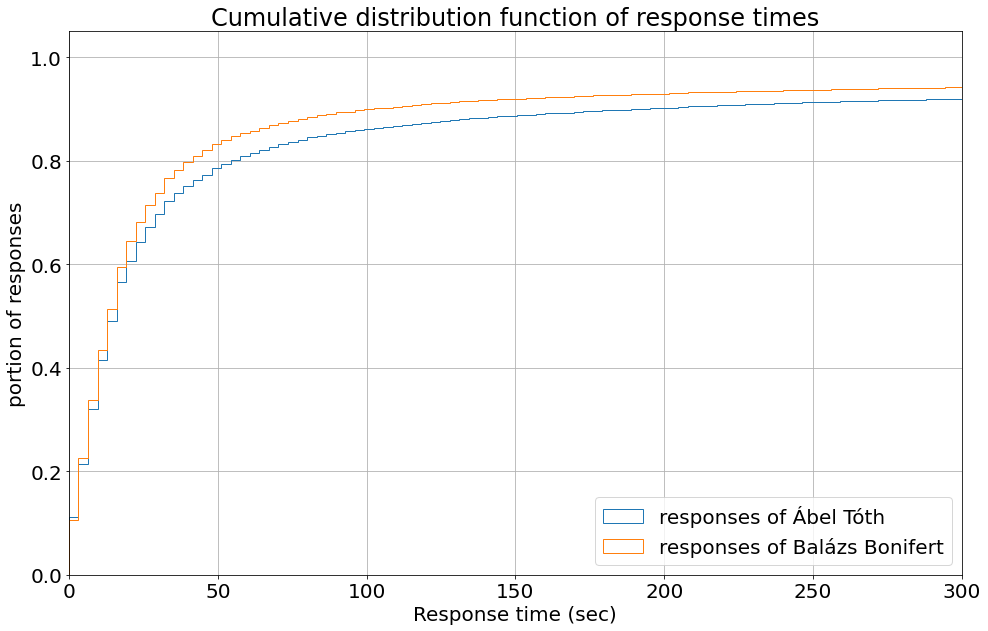

In [22]:
responseTime([threads[1]])